# Quantum Inspire performance test

We compare performance of the simulator with the circuit from 

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

Pieter Eendebak <pieter.eendebak@tno.nl>

# Define the circuit

In [1]:
import time
import numpy as np
from coreapi.auth import BasicAuthentication
from getpass import getpass
from IPython.display import display

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_state, plot_histogram, circuit_drawer

from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit.backend_qx import QiSimulatorPy

In [2]:
def format_vector(state_vector, decimal_precision=7):
    """ Format the state vector into a LaTeX formatted string.

    Args:
        state_vector (list or array): The state vector with complex
                                      values e.g. [-1, 2j+1].

    Returns:
        str: The LaTeX format.
    """
    result = []
    epsilon = 1/pow(10, decimal_precision)
    bit_length = (len(state_vector) - 1).bit_length()
    for index, complex_value in enumerate(state_vector):
        has_imag_part = np.round(complex_value.imag, decimal_precision) != 0.0
        value = complex_value if has_imag_part else complex_value.real
        value_round = np.round(value, decimal_precision)
        if np.abs(value_round) < epsilon:
            continue

        binary_state = '{0:0{1}b}'.format(index, bit_length)
        result.append(r'{0:+2g}\left\lvert {1}\right\rangle '.format(value_round, binary_state))
    return ''.join(result)

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

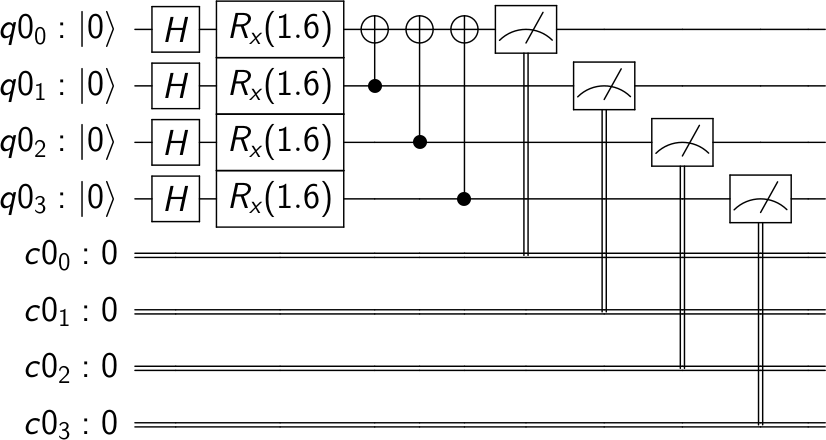

In [3]:
def pcircuit(nqubits, depth = 10):
    """ Circuit to test performance of quantum computer """
    q = QuantumRegister(nqubits)
    ans = ClassicalRegister(nqubits)
    qc = QuantumCircuit(q, ans)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()
            
        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
    for qidx in range(nqubits):
        qc.measure(q[qidx], ans[qidx])
    return q, qc

q,qc = pcircuit(4, 1)
cplot = circuit_drawer(qc)
display(cplot)

# Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [ ]:
try:
    passwd
except:
    print('Enter username')
    username = input();
    print('Enter password')
    passwd = getpass();

uri = r'https://api.quantum-inspire.com/'
authentication = BasicAuthentication(username, passwd)
qi_api = QuantumInspireAPI(uri, authentication, project_name='performance_test_qi')  

_ = qi_api.list_backend_types()

We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [7]:
qiskit_backend = QiSimulatorPy(qi_api)    
job = execute(qc, qiskit_backend)

We can print the results and also show the cQASM that was generated.

In [9]:
print('Generated histogram:')
print(job.get_counts())
print('\nGenerated cQASM:')
print(qiskit_backend.compiled_qasm[0:101] + '\n....\n' + qiskit_backend.compiled_qasm[-100:])

Generated histogram:
{'1': 68.0, '6': 63.0, '10': 65.0, '12': 61.0, '3': 81.0, '9': 65.0, '13': 65.0, '14': 69.0, '5': 56.0, '11': 65.0, '15': 65.0, '8': 56.0, '7': 62.0, '0': 67.0, '2': 45.0, '4': 71.0}

Generated cQASM:
version 1.0
# cqasm generated by QI backend for QisKit
qubits 4
H q[3]
H q[2]
H q[1]
H q[0]
Rz q[0], 
....
, q[0]
CNOT q[3], q[0]
.measurement
   measure q[0]
   measure q[1]
   measure q[2]
   measure q[3]



Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

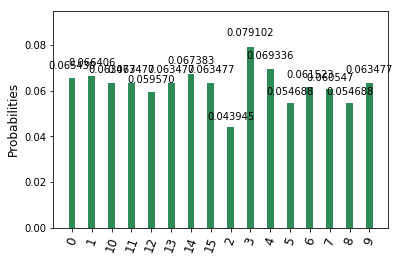

In [11]:
plot_histogram(job.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* QisKit: 3.7 seconds
* ProjectQ: 2.0 seconds

Our simulator runs for multiple shots (unless full state projection is used). More details will follow later.

In [13]:
q, qc = pcircuit(10, 10)
start_time = time.time()

job = execute(qc, qiskit_backend, shots=8)
interval = time.time() - start_time

print('time needed: %.1f [s]' % (interval,))

time needed: 6.7 [s]
